In [11]:
# Instalar SDK java 8

!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Descargar Spark

#!wget -q  https://downloads.apache.org/spark/spark-3.4.4/spark-3.4.4-bin-hadoop3.tgz

# Descomprimir la version de Spark

!tar xf spark-3.4.4-bin-hadoop3.tgz

# Establecer las variables de entorno

import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.4-bin-hadoop3"

In [12]:
from google.colab import userdata
account_key = userdata.get('ACCOUNT_KEY')

In [13]:
# Crear la sesión de Spark

import findspark

findspark.init()

from pyspark.sql import SparkSession

cuenta_almacenamiento = "jtalavera"

spark = (SparkSession.builder
         .config("spark.jars.packages", "org.apache.hadoop:hadoop-azure:3.3.6,com.microsoft.azure:azure-storage:8.6.6")
         .config(f"spark.hadoop.fs.azure.account.key.jtalavera.blob.core.windows.net", account_key)
         .config("spark.hadoop.fs.wasbs.impl", "org.apache.hadoop.fs.azure.NativeAzureFileSystem")
         .config("spark.hadoop.fs.azure", "org.apache.hadoop.fs.azure.NativeAzureFileSystem")
         .getOrCreate())

In [15]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, DateType

# Definir el esquema
schema = StructType([
    StructField("check_in", DateType(), True),
    StructField("check_out", DateType(), True),
    StructField("los", IntegerType(), True),
    StructField("count", IntegerType(), True),
    StructField("rate_price", DoubleType(), True),
    StructField("entity_name", StringType(), True),
    StructField("entity_id", IntegerType(), True),
    StructField("entity_latitude", DoubleType(), True),
    StructField("entity_longitude", DoubleType(), True),
    StructField("entity_city", StringType(), True),
    StructField("entity_type", StringType(), True),
    StructField("entity_stars", IntegerType(), True),
    StructField("rate_name", StringType(), True),
    StructField("rate_id", IntegerType(), True),
    StructField("adults", IntegerType(), True),
    StructField("children", IntegerType(), True),
    StructField("meal_plan", StringType(), True),
    StructField("currency", StringType(), True)
])

In [16]:
archivo = "/2023-07-02/2023-07-03.parquet"
contenedor = "storage"

df = spark.read.parquet(f"wasbs://{contenedor}@{cuenta_almacenamiento}.blob.core.windows.net{archivo}", header=True, schema=schema)
df.show()

+----------+----------+---+-----+----------+--------------------+---------+---------------+------------------+-----------+-----------+------------+----------------+-------+------+--------+------------+--------+
|  check_in| check_out|los|count|rate_price|         entity_name|entity_id|entity_latitude|  entity_longitude|entity_city|entity_type|entity_stars|       rate_name|rate_id|adults|children|   meal_plan|currency|
+----------+----------+---+-----+----------+--------------------+---------+---------------+------------------+-----------+-----------+------------+----------------+-------+------+--------+------------+--------+
|2023-07-03|2023-07-17| 14|    1|      0.98|House from Valenc...|  4160012|          44.52|              7.87|   Valencia|      house|           2|Rate Plan 731559|2662305|     2|       0|allinclusive|     EUR|
|2023-07-03|2023-07-04|  1|    1|      0.56|Hotel_room from S...|  3496726|           40.8|              6.23|  Salamanca| hotel_room|           4|Rate Plan

##Comprobar valores nulos

In [18]:
from pyspark.sql.functions import col, month, when, avg, to_date, count, isnan

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()



+--------+---------+---+-----+----------+-----------+---------+---------------+----------------+-----------+-----------+------------+---------+-------+------+--------+---------+--------+
|check_in|check_out|los|count|rate_price|entity_name|entity_id|entity_latitude|entity_longitude|entity_city|entity_type|entity_stars|rate_name|rate_id|adults|children|meal_plan|currency|
+--------+---------+---+-----+----------+-----------+---------+---------------+----------------+-----------+-----------+------------+---------+-------+------+--------+---------+--------+
|       0|        0|  0|    0|         0|          0|        0|              0|               0|          0|          0|           0|        0|      0|     0|       0|        0|       0|
+--------+---------+---+-----+----------+-----------+---------+---------------+----------------+-----------+-----------+------------+---------+-------+------+--------+---------+--------+



In [ ]:
# Si hay valores nulos en columnas, eliminarlos
#df = df.dropna(subset=["check_in", "check_out", "rate_price", "entity_city"])

## Eliminar filas con rate_price negativo o igual a 0


In [19]:
df = df.filter((col("rate_price") >= 0))

## Redondear latitud y longitud a 2 decimales

In [20]:
from pyspark.sql.functions import round

df = df.withColumn("entity_latitude", round(col("entity_latitude"), 2)) \
       .withColumn("entity_longitude", round(col("entity_longitude"), 2))

##Comprobar que las estrellas de los hoteles tienen el rango correcto

In [21]:
df = df.filter((col("entity_stars") >= 0) & (col("entity_stars") <= 5))

In [22]:
df.show(truncate=False)

+----------+----------+---+-----+----------+---------------------------------+---------+---------------+----------------+-----------+-----------+------------+----------------+-------+------+--------+------------+--------+
|check_in  |check_out |los|count|rate_price|entity_name                      |entity_id|entity_latitude|entity_longitude|entity_city|entity_type|entity_stars|rate_name       |rate_id|adults|children|meal_plan   |currency|
+----------+----------+---+-----+----------+---------------------------------+---------+---------------+----------------+-----------+-----------+------------+----------------+-------+------+--------+------------+--------+
|2023-07-03|2023-07-17|14 |1    |0.98      |House from Valencia 110813       |4160012  |44.52          |7.87            |Valencia   |house      |2           |Rate Plan 731559|2662305|2     |0       |allinclusive|EUR     |
|2023-07-03|2023-07-04|1  |1    |0.56      |Hotel_room from Salamanca 435864 |3496726  |40.8           |6.23    

## Añadir columna de la estación según el día del check in

In [23]:
from pyspark.sql.functions import col, month, dayofmonth, when

# Asignar estación del año basándonos en el mes y el día
df = df.withColumn("season",
    when(((month(col("check_in")) == 12) & (dayofmonth(col("check_in")) >= 21)) | (month(col("check_in")) == 1) | (month(col("check_in")) == 2) | ((month(col("check_in")) == 3) & (dayofmonth(col("check_in")) <= 19)), "Winter")
    .when(((month(col("check_in")) == 3) & (dayofmonth(col("check_in")) >= 20)) | (month(col("check_in")) == 4) | (month(col("check_in")) == 5) | ((month(col("check_in")) == 6) & (dayofmonth(col("check_in")) <= 20)), "Spring")
    .when(((month(col("check_in")) == 6) & (dayofmonth(col("check_in")) >= 21)) | (month(col("check_in")) == 7) | (month(col("check_in")) == 8) | ((month(col("check_in")) == 9) & (dayofmonth(col("check_in")) <= 20)), "Summer")
    .when(((month(col("check_in")) == 9) & (dayofmonth(col("check_in")) >= 21)) | (month(col("check_in")) == 10) | (month(col("check_in")) == 11) | ((month(col("check_in")) == 12) & (dayofmonth(col("check_in")) <= 20)), "Autumn")
)

In [24]:
df.show(truncate=False)

+----------+----------+---+-----+----------+---------------------------------+---------+---------------+----------------+-----------+-----------+------------+----------------+-------+------+--------+------------+--------+------+
|check_in  |check_out |los|count|rate_price|entity_name                      |entity_id|entity_latitude|entity_longitude|entity_city|entity_type|entity_stars|rate_name       |rate_id|adults|children|meal_plan   |currency|season|
+----------+----------+---+-----+----------+---------------------------------+---------+---------------+----------------+-----------+-----------+------------+----------------+-------+------+--------+------------+--------+------+
|2023-07-03|2023-07-17|14 |1    |0.98      |House from Valencia 110813       |4160012  |44.52          |7.87            |Valencia   |house      |2           |Rate Plan 731559|2662305|2     |0       |allinclusive|EUR     |Summer|
|2023-07-03|2023-07-04|1  |1    |0.56      |Hotel_room from Salamanca 435864 |349672

##Agrupar los datos por ciudad y estación y calcular la media de rate_price

In [25]:
df_grouped = df.groupBy("entity_city", "season").agg(avg("rate_price").alias("avg_rate_price"))

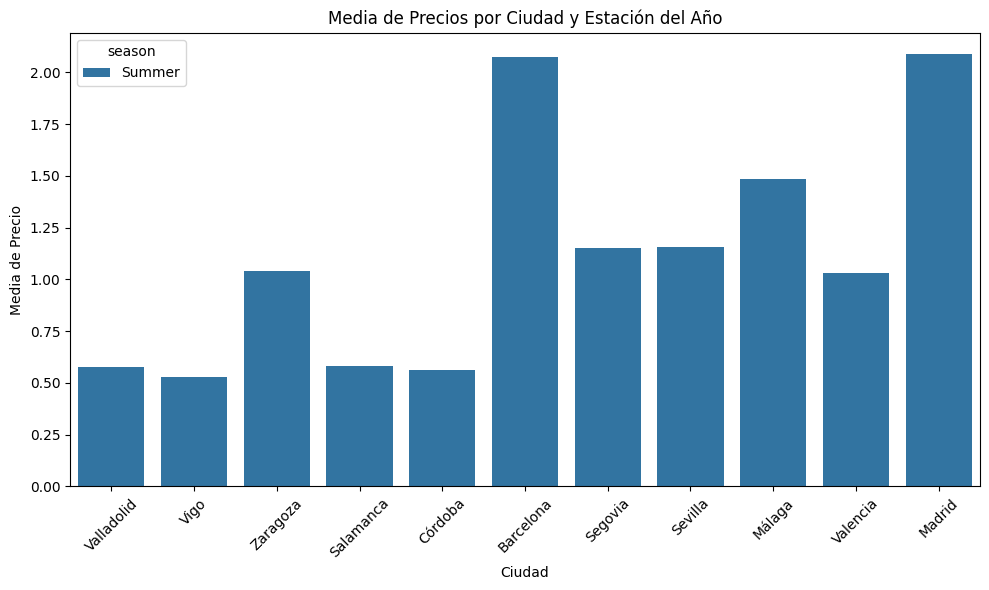

In [26]:
# Convertir el DataFrame de Spark a Pandas para graficar
df_pandas = df_grouped.toPandas()

# Graficar con seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
sns.barplot(x="entity_city", y="avg_rate_price", hue="season", data=df_pandas)

# Configurar la gráfica
plt.title("Media de Precios por Ciudad y Estación del Año")
plt.xlabel("Ciudad")
plt.ylabel("Media de Precio")
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar la gráfica
plt.show()
